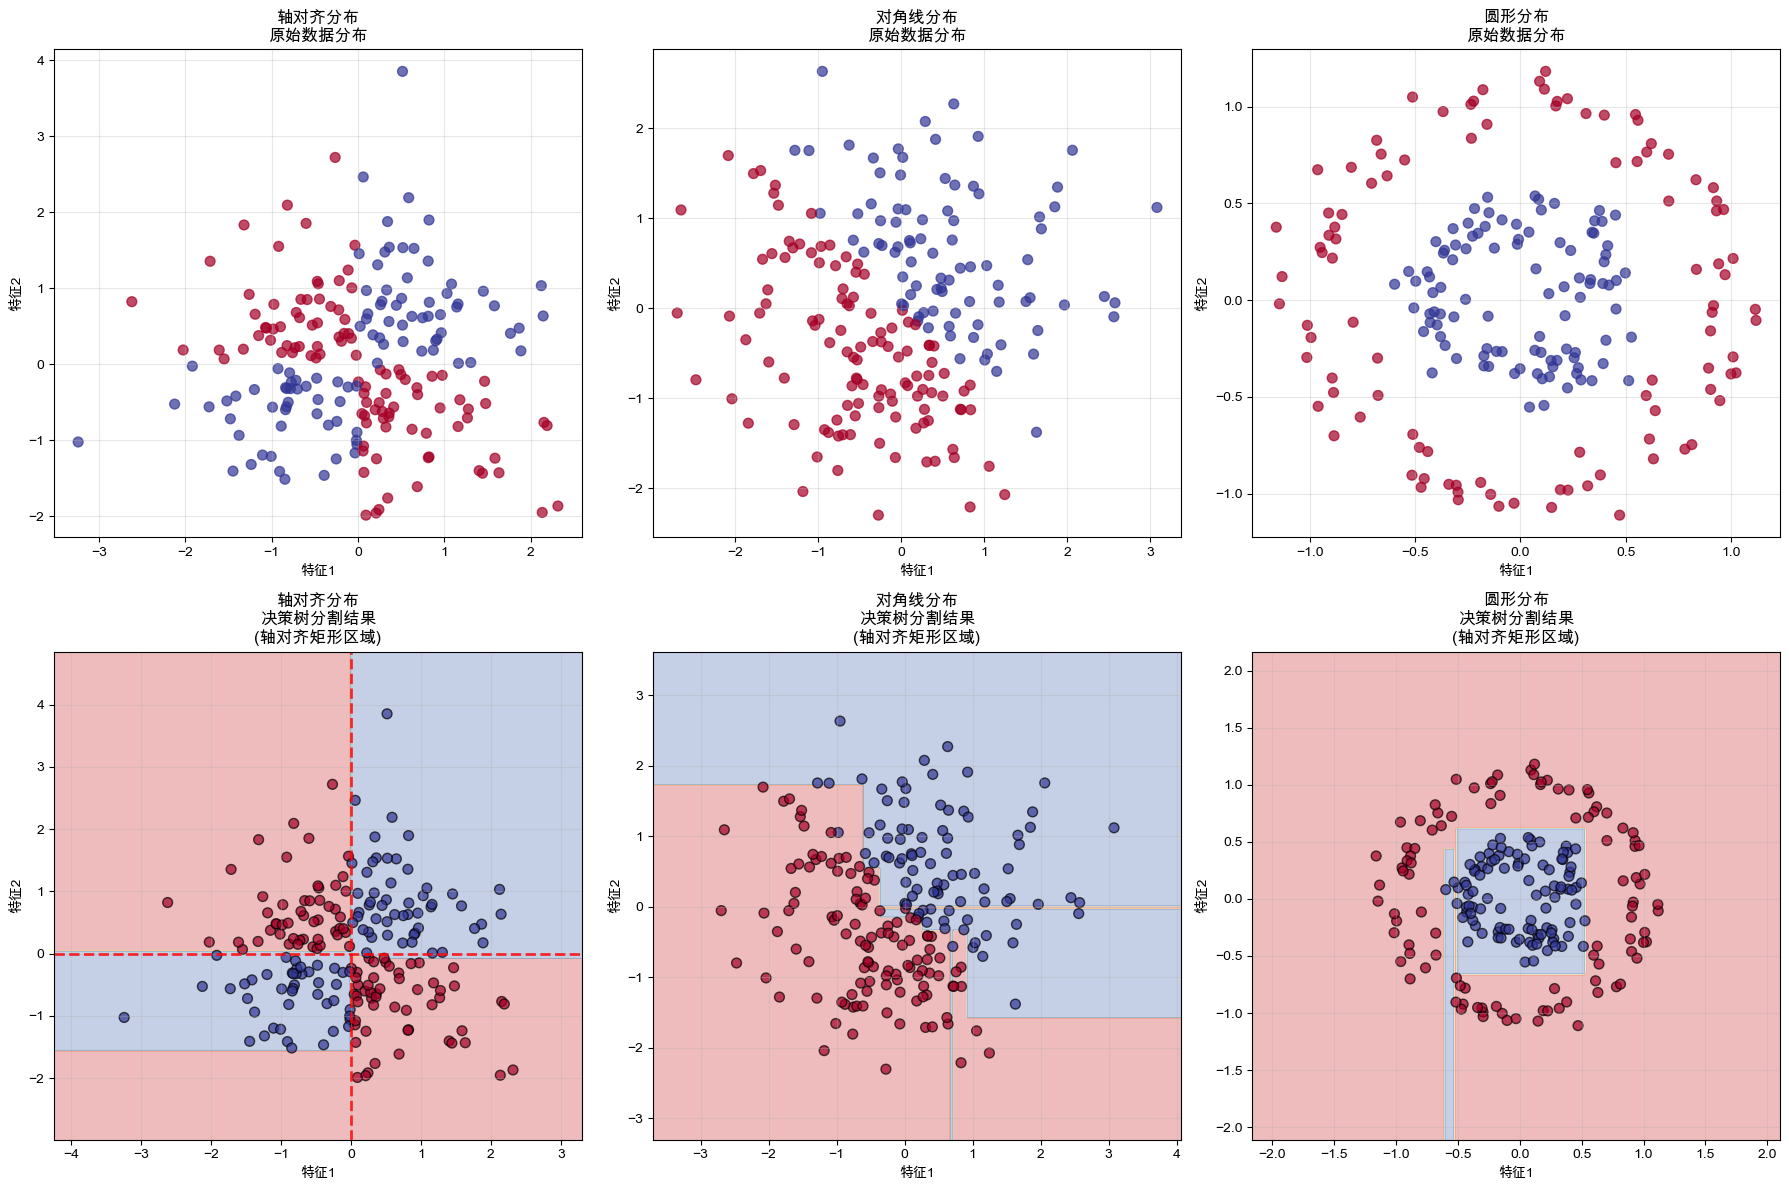

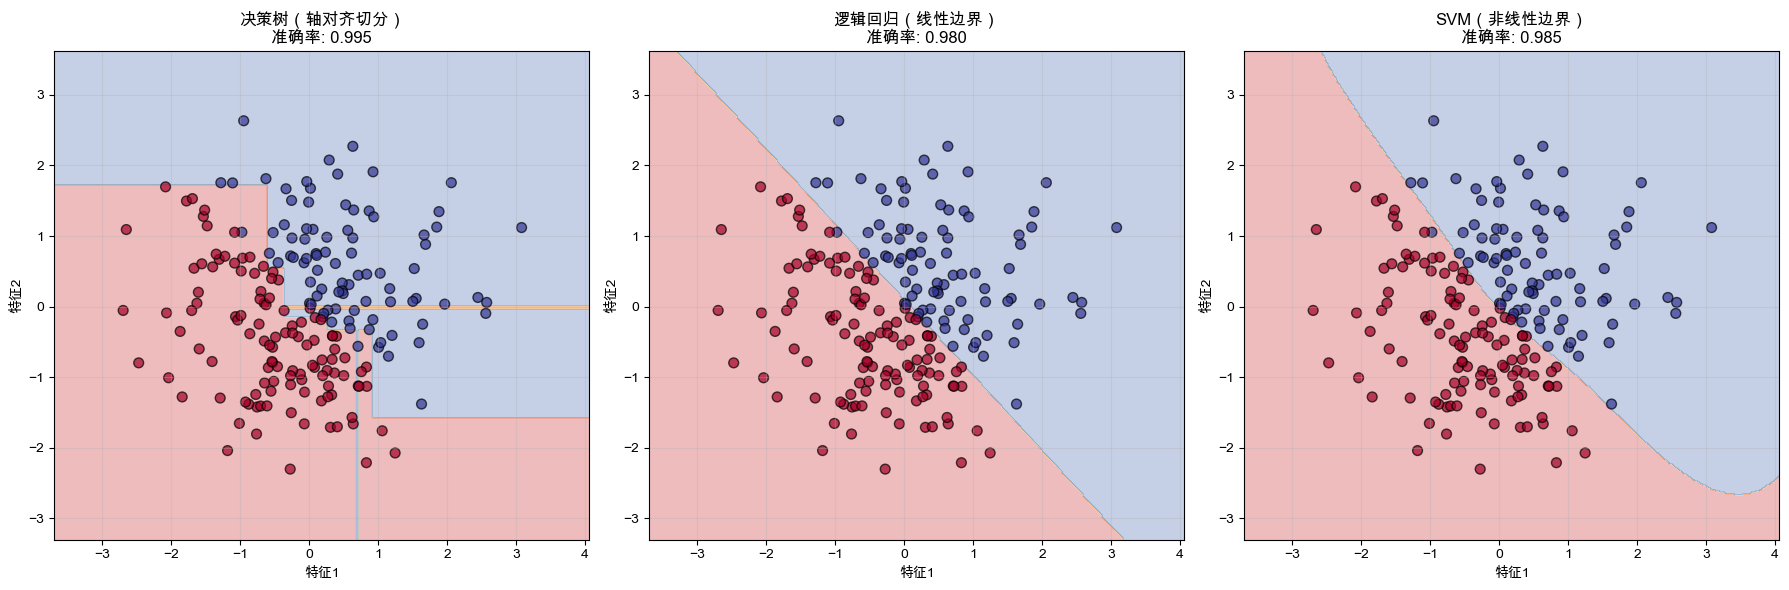

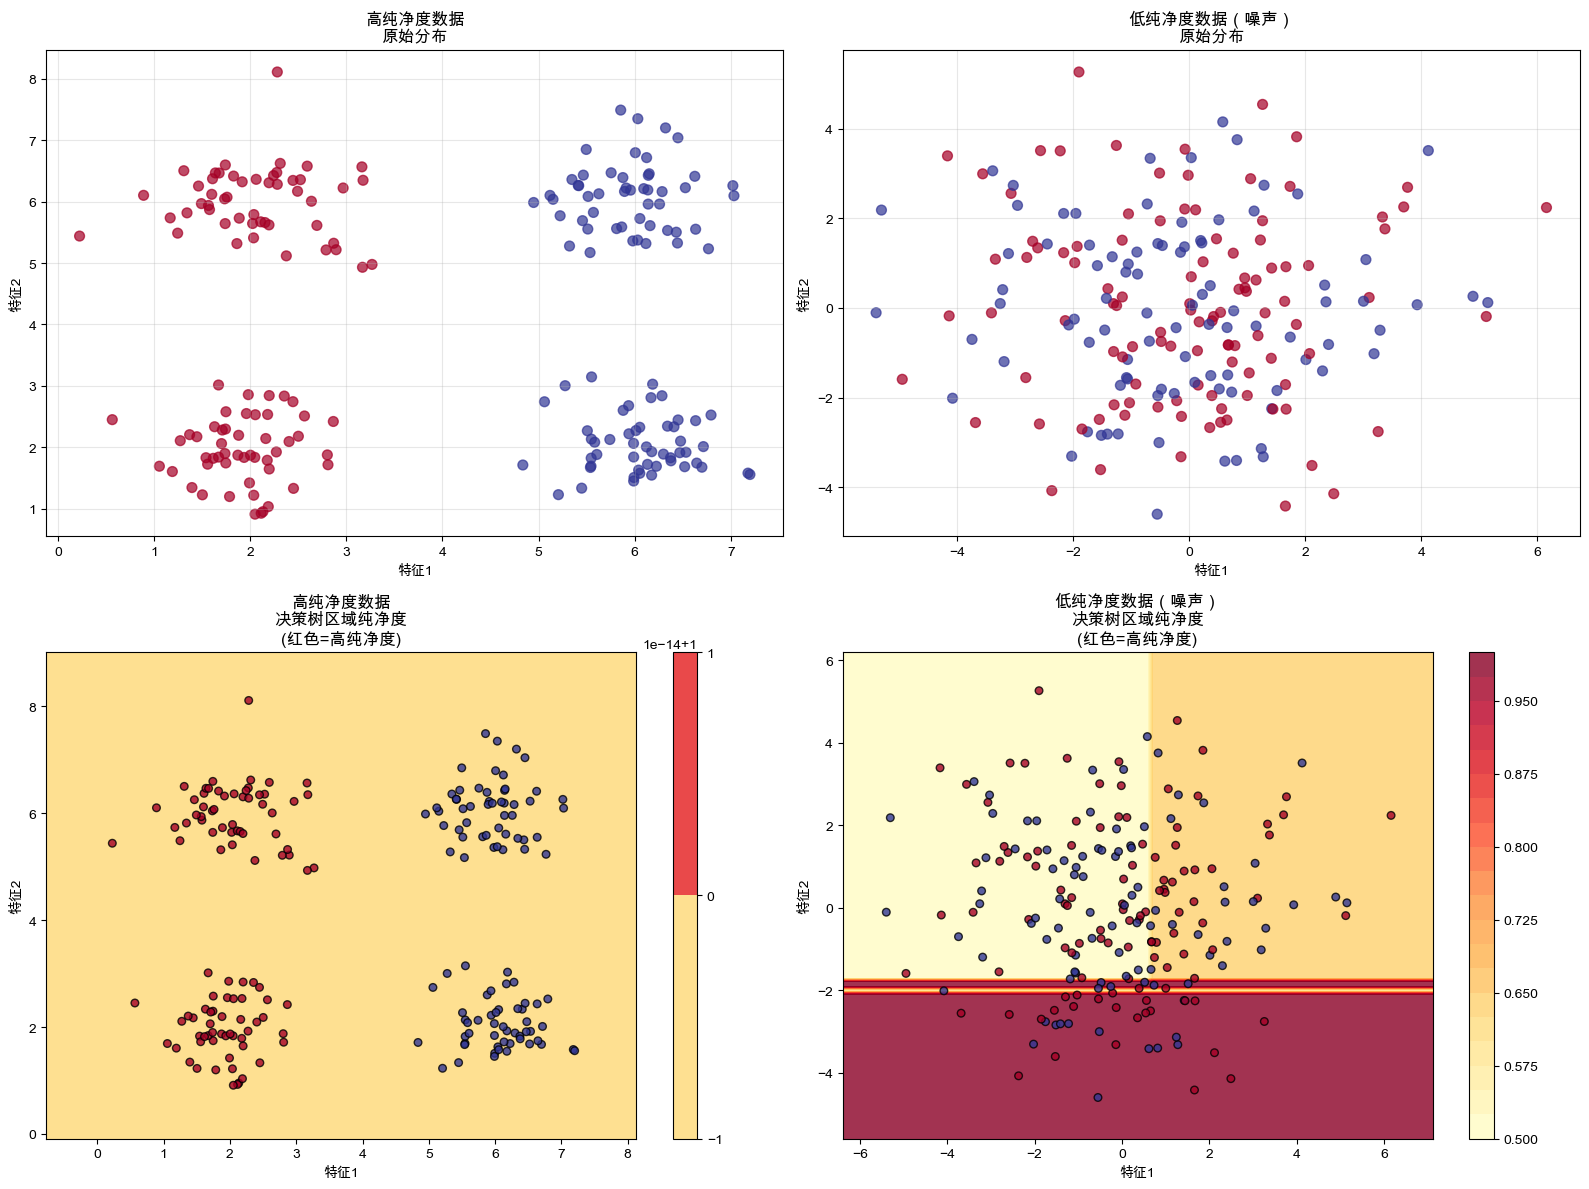

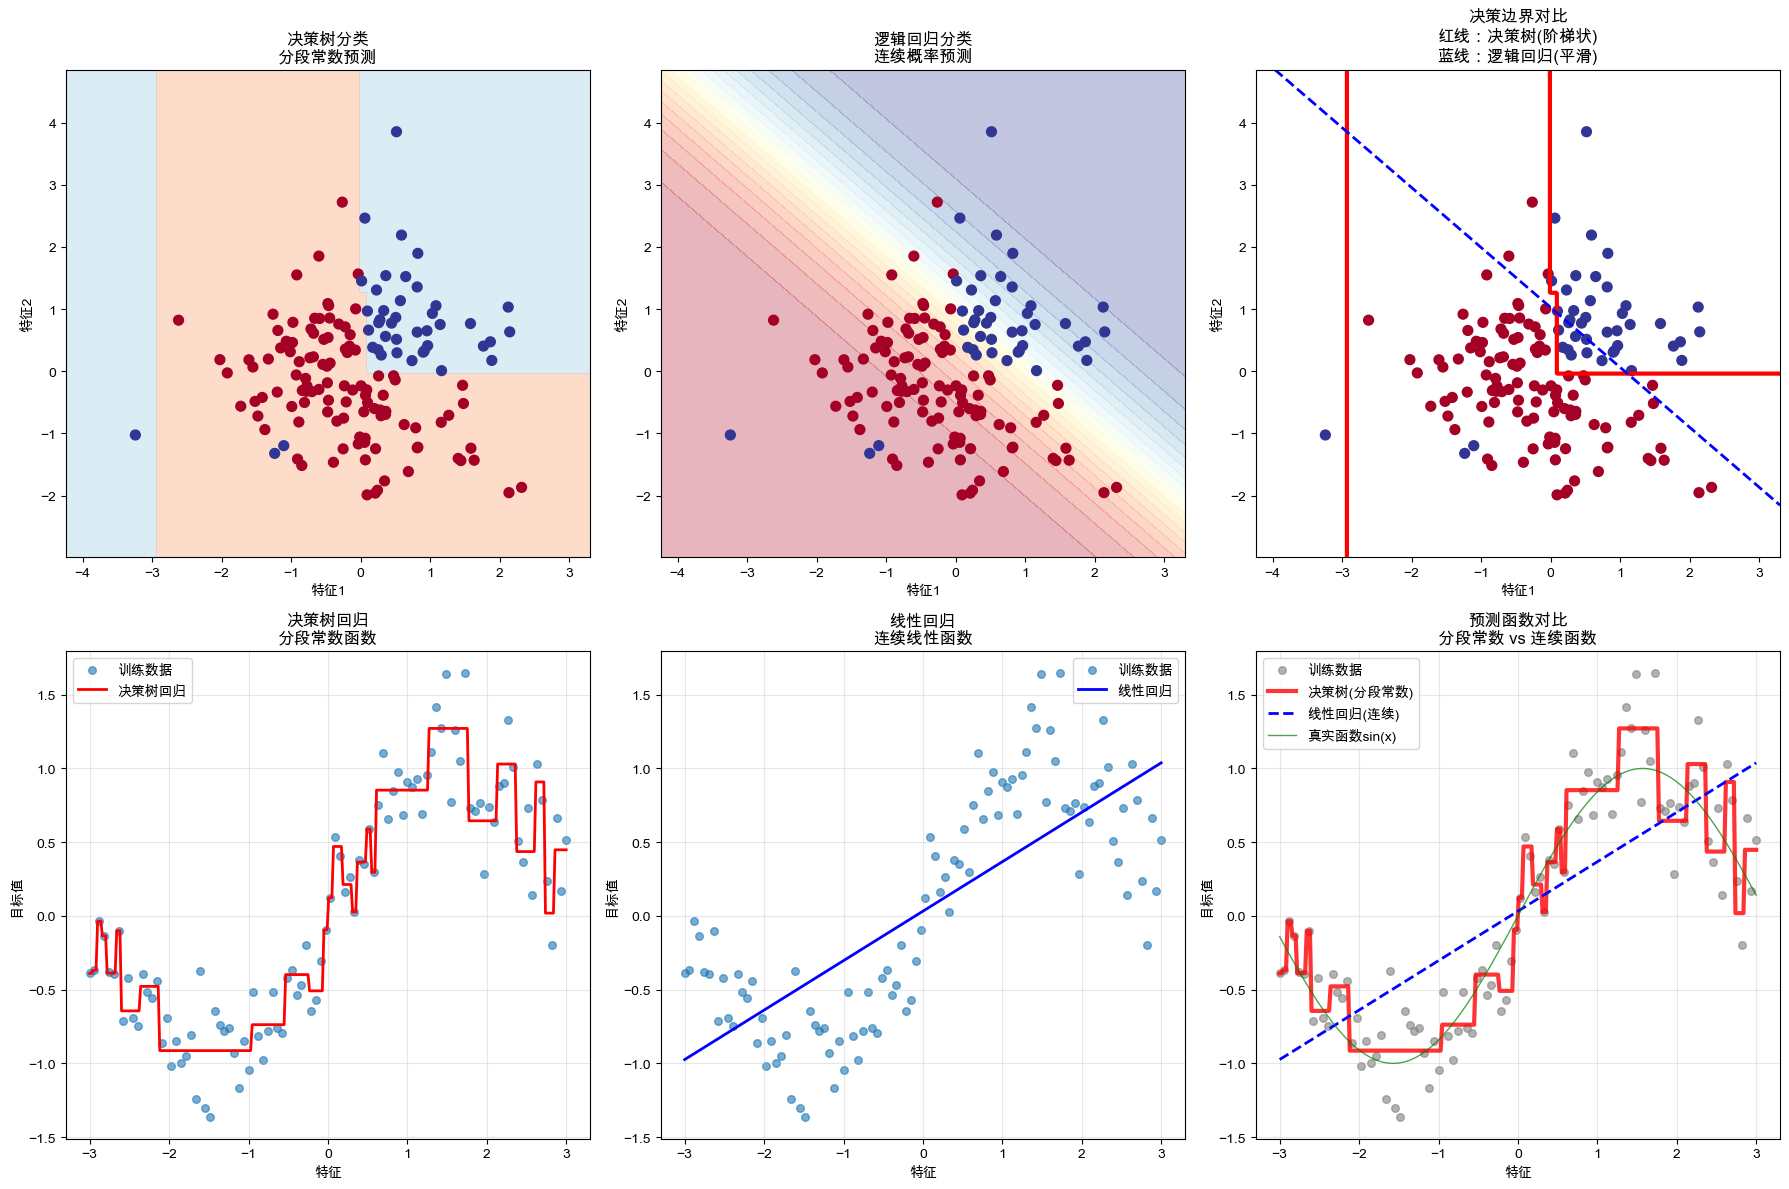

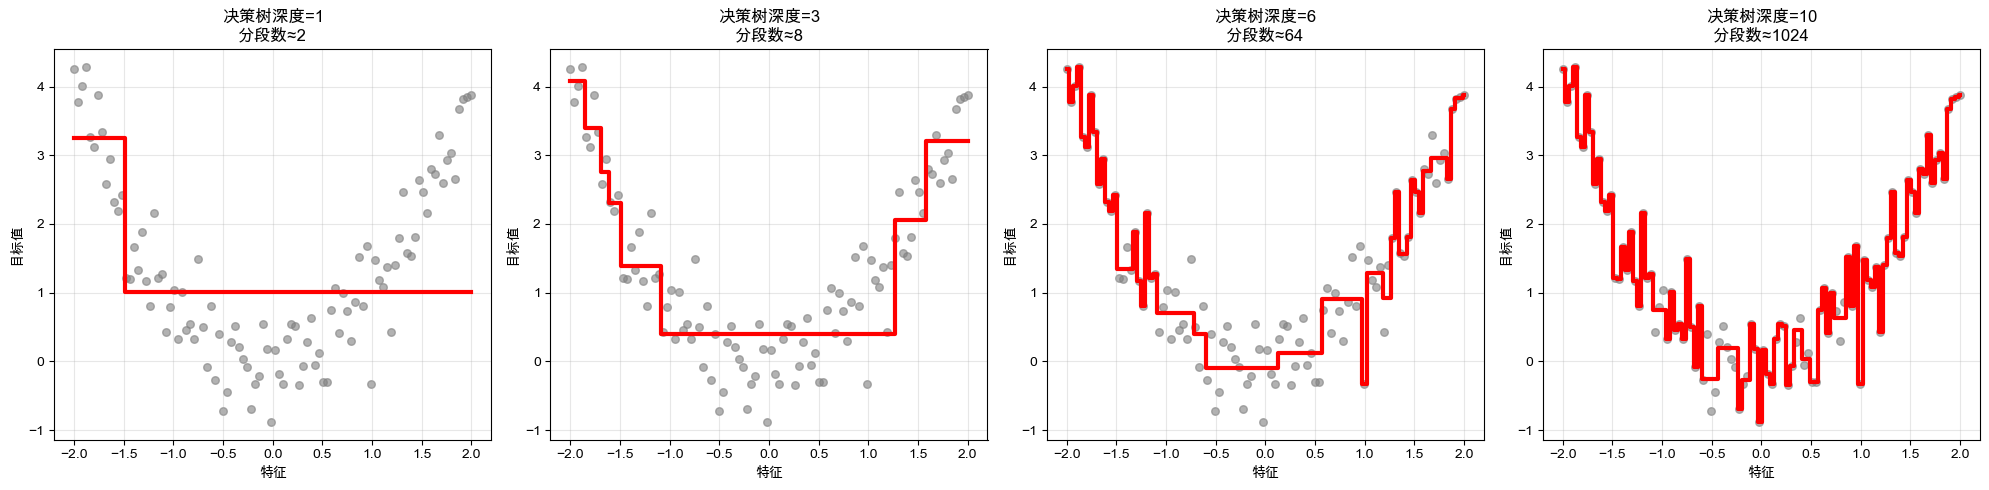

决策树的三个核心模型假设

1. 特征空间可被递归地划分成若干个区域
   ✓ 数据分布可以通过'逐步二分（或多分）'操作来切分
   ✓ 每次划分都是单一特征上的阈值比较（轴对齐切分）
   ✗ 不适合对角线或圆形等需要非轴对齐分割的数据

2. 每个区域内部是相对'纯净'的
   ✓ 分类树：区域内样本属于同一类别（或大部分属于同一类别）
   ✓ 回归树：区域内目标值接近一个常数
   ✗ 高噪声数据会导致区域纯净度低，模型性能下降

3. 预测方式是分区常数模型
   ✓ 决策树是分段常数函数（piecewise constant function）
   ✓ 输入空间被划分为多个矩形区域，每个区域给出固定预测值
   ✗ 无法产生平滑的预测边界，可能出现过拟合


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_classification, make_regression, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial Unicode MS'

# ==================== 假设1: 特征空间可被递归地划分成若干个区域 ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 创建不同类型的数据
np.random.seed(42)

# 1.1 适合轴对齐切分的数据
X_aligned = np.random.randn(200, 2)
y_aligned = ((X_aligned[:, 0] > 0) & (X_aligned[:, 1] > 0)).astype(int) | \
           ((X_aligned[:, 0] < 0) & (X_aligned[:, 1] < 0)).astype(int)

# 1.2 不适合轴对齐切分的数据（对角线分布）
X_diagonal = np.random.randn(200, 2)
y_diagonal = (X_diagonal[:, 0] + X_diagonal[:, 1] > 0).astype(int)

# 1.3 圆形分布数据
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.4, random_state=42)

datasets = [(X_aligned, y_aligned, '轴对齐分布'), 
           (X_diagonal, y_diagonal, '对角线分布'), 
           (X_circles, y_circles, '圆形分布')]

# 绘制原始数据分布
for i, (X, y, title) in enumerate(datasets):
    axes[0, i].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=50, alpha=0.7)
    axes[0, i].set_title(f'{title}\n原始数据分布', fontsize=12)
    axes[0, i].set_xlabel('特征1')
    axes[0, i].set_ylabel('特征2')
    axes[0, i].grid(True, alpha=0.3)

# 使用决策树进行分类并可视化决策边界
for i, (X, y, title) in enumerate(datasets):
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X, y)
    
    # 创建网格
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 预测
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘制决策边界（矩形区域）
    axes[1, i].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    axes[1, i].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=50, 
                      edgecolors='black', alpha=0.7)
    
    # 添加轴对齐的分割线
    # 这里简化展示主要的分割线
    if i == 0:  # 轴对齐数据效果好
        axes[1, i].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8)
        axes[1, i].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    axes[1, i].set_title(f'{title}\n决策树分割结果\n(轴对齐矩形区域)', fontsize=12)
    axes[1, i].set_xlabel('特征1')
    axes[1, i].set_ylabel('特征2')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 对比不同算法在对角线数据上的表现
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

algorithms = [
    (DecisionTreeClassifier(max_depth=5, random_state=42), '决策树（轴对齐切分）'),
    (LogisticRegression(random_state=42), '逻辑回归（线性边界）'),
    (SVC(kernel='rbf', C=1.0, random_state=42), 'SVM（非线性边界）')
]

for i, (clf, name) in enumerate(algorithms):
    clf.fit(X_diagonal, y_diagonal)
    
    # 创建网格
    h = 0.02
    x_min, x_max = X_diagonal[:, 0].min() - 1, X_diagonal[:, 0].max() + 1
    y_min, y_max = X_diagonal[:, 1].min() - 1, X_diagonal[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    axes[i].scatter(X_diagonal[:, 0], X_diagonal[:, 1], c=y_diagonal, 
                   cmap='RdYlBu', s=50, edgecolors='black', alpha=0.7)
    axes[i].set_title(f'{name}\n准确率: {clf.score(X_diagonal, y_diagonal):.3f}', fontsize=12)
    axes[i].set_xlabel('特征1')
    axes[i].set_ylabel('特征2')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 假设2: 每个区域内部是相对"纯净"的 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 创建适合和不适合纯净假设的数据
np.random.seed(42)

# 2.1 纯净度高的数据（聚类明显）
centers_pure = [[2, 2], [6, 6], [2, 6], [6, 2]]
X_pure = []
y_pure = []
for i, center in enumerate(centers_pure):
    cluster = np.random.multivariate_normal(center, [[0.3, 0], [0, 0.3]], 50)
    X_pure.append(cluster)
    y_pure.append(np.full(50, i % 2))  # 二分类

X_pure = np.vstack(X_pure)
y_pure = np.hstack(y_pure)

# 2.2 纯净度低的数据（噪声大，混合严重）
X_noisy = np.random.randn(200, 2) * 2
y_noisy = np.random.randint(0, 2, 200)  # 随机标签，模拟噪声

datasets_purity = [(X_pure, y_pure, '高纯净度数据'), 
                  (X_noisy, y_noisy, '低纯净度数据（噪声）')]

for i, (X, y, title) in enumerate(datasets_purity):
    # 原始数据
    axes[0, i].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=50, alpha=0.7)
    axes[0, i].set_title(f'{title}\n原始分布', fontsize=12)
    axes[0, i].set_xlabel('特征1')
    axes[0, i].set_ylabel('特征2')
    axes[0, i].grid(True, alpha=0.3)
    
    # 决策树分割后的区域纯净度
    dt = DecisionTreeClassifier(max_depth=4, random_state=42)
    dt.fit(X, y)
    
    # 创建网格并计算每个区域的纯净度
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 预测概率来表示纯净度
    Z_proba = dt.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # 计算每个点的不确定性（熵）
    Z_purity = np.maximum(Z_proba[:, 0], Z_proba[:, 1])  # 最大概率，纯净度越高
    Z_purity = Z_purity.reshape(xx.shape)
    
    # 绘制纯净度热图
    im = axes[1, i].contourf(xx, yy, Z_purity, levels=20, cmap='YlOrRd', alpha=0.8)
    axes[1, i].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', s=30, 
                      edgecolors='black', alpha=0.8)
    axes[1, i].set_title(f'{title}\n决策树区域纯净度\n(红色=高纯净度)', fontsize=12)
    axes[1, i].set_xlabel('特征1')
    axes[1, i].set_ylabel('特征2')
    plt.colorbar(im, ax=axes[1, i])

plt.tight_layout()
plt.show()

# ==================== 假设3: 预测方式是分区常数模型 ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 3.1 分类问题的分段常数
np.random.seed(42)
X_class = np.random.randn(150, 2)
y_class = ((X_class[:, 0] > 0) & (X_class[:, 1] > 0)).astype(int) | \
         ((X_class[:, 0] < -1) & (X_class[:, 1] < -1)).astype(int)

# 3.2 回归问题
X_reg = np.linspace(-3, 3, 100).reshape(-1, 1)
y_reg = np.sin(X_reg.ravel()) + 0.3 * np.random.randn(100)

# 分类问题：分段常数 vs 连续边界
dt_class = DecisionTreeClassifier(max_depth=4, random_state=42)
lr_class = LogisticRegression(random_state=42)

dt_class.fit(X_class, y_class)
lr_class.fit(X_class, y_class)

# 创建网格
h = 0.02
x_min, x_max = X_class[:, 0].min() - 1, X_class[:, 0].max() + 1
y_min, y_max = X_class[:, 1].min() - 1, X_class[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 决策树预测（分段常数）
Z_dt = dt_class.predict(np.c_[xx.ravel(), yy.ravel()])
Z_dt = Z_dt.reshape(xx.shape)

# 逻辑回归预测概率（连续）
Z_lr = lr_class.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_lr = Z_lr.reshape(xx.shape)

# 绘制分类结果对比
axes[0, 0].contourf(xx, yy, Z_dt, alpha=0.3, cmap='RdYlBu', levels=[0, 0.5, 1])
axes[0, 0].scatter(X_class[:, 0], X_class[:, 1], c=y_class, cmap='RdYlBu', s=50)
axes[0, 0].set_title('决策树分类\n分段常数预测', fontsize=12)
axes[0, 0].set_xlabel('特征1')
axes[0, 0].set_ylabel('特征2')

axes[0, 1].contourf(xx, yy, Z_lr, alpha=0.3, cmap='RdYlBu', levels=20)
axes[0, 1].scatter(X_class[:, 0], X_class[:, 1], c=y_class, cmap='RdYlBu', s=50)
axes[0, 1].set_title('逻辑回归分类\n连续概率预测', fontsize=12)
axes[0, 1].set_xlabel('特征1')
axes[0, 1].set_ylabel('特征2')

# 显示决策边界的"阶梯"特性
axes[0, 2].contour(xx, yy, Z_dt, levels=[0.5], colors='red', linewidths=3, linestyles='-')
axes[0, 2].contour(xx, yy, Z_lr, levels=[0.5], colors='blue', linewidths=2, linestyles='--')
axes[0, 2].scatter(X_class[:, 0], X_class[:, 1], c=y_class, cmap='RdYlBu', s=50)
axes[0, 2].set_title('决策边界对比\n红线：决策树(阶梯状)\n蓝线：逻辑回归(平滑)', fontsize=12)
axes[0, 2].set_xlabel('特征1')
axes[0, 2].set_ylabel('特征2')

# 回归问题：分段常数 vs 连续函数
dt_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
lr_reg = LinearRegression()

dt_reg.fit(X_reg, y_reg)
lr_reg.fit(X_reg, y_reg)

# 创建预测网格
X_plot = np.linspace(-3, 3, 300).reshape(-1, 1)
y_dt_pred = dt_reg.predict(X_plot)
y_lr_pred = lr_reg.predict(X_plot)

# 绘制回归结果
axes[1, 0].scatter(X_reg, y_reg, alpha=0.6, s=30, label='训练数据')
axes[1, 0].plot(X_plot, y_dt_pred, 'red', linewidth=2, label='决策树回归')
axes[1, 0].set_title('决策树回归\n分段常数函数', fontsize=12)
axes[1, 0].set_xlabel('特征')
axes[1, 0].set_ylabel('目标值')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(X_reg, y_reg, alpha=0.6, s=30, label='训练数据')
axes[1, 1].plot(X_plot, y_lr_pred, 'blue', linewidth=2, label='线性回归')
axes[1, 1].set_title('线性回归\n连续线性函数', fontsize=12)
axes[1, 1].set_xlabel('特征')
axes[1, 1].set_ylabel('目标值')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 叠加显示两种方法
axes[1, 2].scatter(X_reg, y_reg, alpha=0.6, s=30, label='训练数据', color='gray')
axes[1, 2].plot(X_plot, y_dt_pred, 'red', linewidth=3, label='决策树(分段常数)', alpha=0.8)
axes[1, 2].plot(X_plot, y_lr_pred, 'blue', linewidth=2, label='线性回归(连续)', linestyle='--')
axes[1, 2].plot(X_plot, np.sin(X_plot.ravel()), 'green', linewidth=1, 
               label='真实函数sin(x)', alpha=0.7)
axes[1, 2].set_title('预测函数对比\n分段常数 vs 连续函数', fontsize=12)
axes[1, 2].set_xlabel('特征')
axes[1, 2].set_ylabel('目标值')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 决策树深度对分段常数的影响 ====================
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 生成测试数据
np.random.seed(42)
X_depth = np.linspace(-2, 2, 100).reshape(-1, 1)
y_depth = X_depth.ravel()**2 + 0.5 * np.random.randn(100)

depths = [1, 3, 6, 10]

for i, depth in enumerate(depths):
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_depth, y_depth)
    
    X_plot = np.linspace(-2, 2, 300).reshape(-1, 1)
    y_pred = dt.predict(X_plot)
    
    axes[i].scatter(X_depth, y_depth, alpha=0.6, s=30, color='gray')
    axes[i].plot(X_plot, y_pred, 'red', linewidth=3, drawstyle='steps-post')
    axes[i].set_title(f'决策树深度={depth}\n分段数≈{2**depth}', fontsize=12)
    axes[i].set_xlabel('特征')
    axes[i].set_ylabel('目标值')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印总结
print("=" * 80)
print("决策树的三个核心模型假设")
print("=" * 80)
print("\n1. 特征空间可被递归地划分成若干个区域")
print("   ✓ 数据分布可以通过'逐步二分（或多分）'操作来切分")
print("   ✓ 每次划分都是单一特征上的阈值比较（轴对齐切分）")
print("   ✗ 不适合对角线或圆形等需要非轴对齐分割的数据")

print("\n2. 每个区域内部是相对'纯净'的")
print("   ✓ 分类树：区域内样本属于同一类别（或大部分属于同一类别）")
print("   ✓ 回归树：区域内目标值接近一个常数")
print("   ✗ 高噪声数据会导致区域纯净度低，模型性能下降")

print("\n3. 预测方式是分区常数模型")
print("   ✓ 决策树是分段常数函数（piecewise constant function）")
print("   ✓ 输入空间被划分为多个矩形区域，每个区域给出固定预测值")
print("   ✗ 无法产生平滑的预测边界，可能出现过拟合")

In [ ]:
import numpy as np

class MyDecisionTree:
    def __init__(self, criterion="ID3", max_depth=None, min_samples_split=2, 
                 min_impurity_decrease=0.0, max_leaf_nodes=None, min_weight_fraction_leaf=0.0):
        """
        criterion: "ID3", "C4.5", "CART"
        max_depth: 最大深度
        min_samples_split: 节点继续分裂所需的最小样本数
        min_impurity_decrease: 最小信息增益/基尼指数下降，低于该值不分裂
        max_leaf_nodes: 最大叶子节点数
        min_weight_fraction_leaf: 叶子节点至少包含的样本权重比例
        """
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.max_leaf_nodes = max_leaf_nodes
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.tree = None
        self._leaf_count = 0   # 跟踪当前叶子数量

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-9))

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def _information_gain(self, X_column, y):
        H = self._entropy(y)
        values, counts = np.unique(X_column, return_counts=True)
        weighted_entropy = 0
        for v, c in zip(values, counts):
            weighted_entropy += (c/len(y)) * self._entropy(y[X_column == v])
        return H - weighted_entropy

    def _gain_ratio(self, X_column, y):
        info_gain = self._information_gain(X_column, y)
        _, counts = np.unique(X_column, return_counts=True)
        split_info = -np.sum((counts/len(y)) * np.log2(counts/len(y) + 1e-9))
        return info_gain / (split_info + 1e-9)

    def _gini_gain(self, X_column, y):
        G = self._gini(y)
        values, counts = np.unique(X_column, return_counts=True)
        weighted_gini = 0
        for v, c in zip(values, counts):
            weighted_gini += (c/len(y)) * self._gini(y[X_column == v])
        return G - weighted_gini

    def _calc_impurity_gain(self, X_column, y):
        if self.criterion == "ID3":
            return self._information_gain(X_column, y)
        elif self.criterion == "C4.5":
            return self._gain_ratio(X_column, y)
        elif self.criterion == "CART":
            return self._gini_gain(X_column, y)
        else:
            raise ValueError("Unsupported criterion")

    def best_split(self, X, y):
        n_features = X.shape[1]
        best_feature, best_score = None, -1

        for feature in range(n_features):
            X_column = X[:, feature]
            score = self._calc_impurity_gain(X_column, y)

            if score > best_score:
                best_score = score
                best_feature = feature

        return best_feature, best_score

    def build_tree(self, X, y, depth=0, total_samples=None):
        if total_samples is None:
            total_samples = len(y)

        labels, counts = np.unique(y, return_counts=True)
        
        if len(labels) == 1:  # 纯节点
            self._leaf_count += 1
            return labels[0]
        if self.max_depth is not None and depth >= self.max_depth:
            self._leaf_count += 1
            return labels[np.argmax(counts)]
        if len(y) < self.min_samples_split:
            self._leaf_count += 1
            return labels[np.argmax(counts)]
        if self.max_leaf_nodes is not None and self._leaf_count >= self.max_leaf_nodes:
            return labels[np.argmax(counts)]

        best_feature, best_score = self.best_split(X, y)
        if best_feature is None or best_score < self.min_impurity_decrease:
            self._leaf_count += 1
            return labels[np.argmax(counts)]

        tree = {"feature": best_feature, "children": {}}
        values = np.unique(X[:, best_feature])

        for v in values:
            idx = X[:, best_feature] == v
            # min_weight_fraction_leaf 检查
            if sum(idx) < self.min_weight_fraction_leaf * total_samples:
                # 如果不满足要求 → 直接当作叶子
                tree["children"][v] = labels[np.argmax(counts)]
            else:
                subtree = self.build_tree(X[idx], y[idx], depth+1, total_samples)
                tree["children"][v] = subtree

        return tree

    def fit(self, X, y):
        self._leaf_count = 0
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree["feature"]
        value = x[feature]
        if value in tree["children"]:
            return self.predict_one(x, tree["children"][value])
        else:
            return None

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])
    
    def score(self, X, y):
        """ 计算准确率 """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


构建的树: {'feature': 0, 'children': {np.str_('晴'): np.str_('否'), np.str_('阴'): np.str_('是'), np.str_('雨'): {'feature': 3, 'children': {np.str_('否'): np.str_('是'), np.str_('是'): np.str_('否')}}}}
预测结果: ['否' '否' '是' '是' '是' '否' '是']


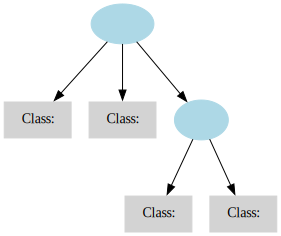

In [ ]:
from graphviz import Digraph
from IPython.display import display

# ============ 示例 ============
if __name__ == "__main__":
    X = np.array([
        ["晴", "热", "高", "否"],
        ["晴", "热", "高", "是"],
        ["阴", "热", "高", "否"],
        ["雨", "温和", "高", "否"],
        ["雨", "凉", "正常", "否"],
        ["雨", "凉", "正常", "是"],
        ["阴", "凉", "正常", "是"],
    ])
    y = np.array(["否", "否", "是", "是", "是", "否", "是"])

    tree = MyDecisionTree(criterion="C4.5", max_depth=3, min_impurity_decrease=0.01, 
                          max_leaf_nodes=5, min_weight_fraction_leaf=0.1)
    tree.fit(X, y)
    print("构建的树:", tree.tree)
    preds = tree.predict(X)
    print("预测结果:", preds)

def visualize_tree(tree, feature_names):
    """
    tree: MyDecisionTree.tree
    feature_names: 列名列表，例如 ["天气", "温度", "湿度", "风"]
    """
    dot = Digraph()
    
    def add_nodes_edges(tree, parent=None, edge_label=""):
        if not isinstance(tree, dict):
            # 叶子节点显示类别
            node_id = str(id(tree))
            dot.node(node_id, f"Class: {tree}", shape="box", style="filled", color="lightgrey")
            if parent is not None:
                dot.edge(parent, node_id, label=edge_label)
            return node_id
        else:
            feature_idx = tree["feature"]
            node_label = feature_names[feature_idx]
            node_id = str(id(tree))
            dot.node(node_id, node_label, shape="ellipse", style="filled", color="lightblue")
            if parent is not None:
                dot.edge(parent, node_id, label=edge_label)
            for value, subtree in tree["children"].items():
                add_nodes_edges(subtree, node_id, str(value))
            return node_id
    
    add_nodes_edges(tree)
    display(dot)

# 使用示例
feature_names = ["天气", "温度", "湿度", "风"]
visualize_tree(tree.tree, feature_names)


In [ ]:
import torch

class MyDecisionTree_Torch:
    def __init__(self, criterion="ID3", max_depth=None, min_samples_split=2, 
                 min_impurity_decrease=0.0, max_leaf_nodes=None, min_weight_fraction_leaf=0.0):
        """
        criterion: "ID3", "C4.5", "CART"
        max_depth: 最大深度
        min_samples_split: 节点继续分裂所需的最小样本数
        min_impurity_decrease: 最小信息增益/基尼指数下降，低于该值不分裂
        max_leaf_nodes: 最大叶子节点数
        min_weight_fraction_leaf: 叶子节点至少包含的样本权重比例
        """
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.max_leaf_nodes = max_leaf_nodes
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.tree = None
        self._leaf_count = 0   # 跟踪当前叶子数量

    def _entropy(self, y):
        _, counts = torch.unique(y, return_counts=True)
        probs = counts.float() / counts.sum()
        return -(probs * torch.log2(probs + 1e-9)).sum()

    def _gini(self, y):
        _, counts = torch.unique(y, return_counts=True)
        probs = counts.float() / counts.sum()
        return 1 - (probs ** 2).sum()

    def _information_gain(self, X_column, y):
        H = self._entropy(y)
        values, counts = torch.unique(X_column, return_counts=True)
        weighted_entropy = torch.tensor(0.0)
        for v, c in zip(values, counts):
            weighted_entropy += (c.float()/len(y)) * self._entropy(y[X_column == v])
        return H - weighted_entropy

    def _gain_ratio(self, X_column, y):
        info_gain = self._information_gain(X_column, y)
        _, counts = torch.unique(X_column, return_counts=True)
        probs = counts.float() / len(y)
        split_info = -(probs * torch.log2(probs + 1e-9)).sum()
        return info_gain / (split_info + 1e-9)

    def _gini_gain(self, X_column, y):
        G = self._gini(y)
        values, counts = torch.unique(X_column, return_counts=True)
        weighted_gini = torch.tensor(0.0)
        for v, c in zip(values, counts):
            weighted_gini += (c.float()/len(y)) * self._gini(y[X_column == v])
        return G - weighted_gini

    def _calc_impurity_gain(self, X_column, y):
        if self.criterion == "ID3":
            return self._information_gain(X_column, y)
        elif self.criterion == "C4.5":
            return self._gain_ratio(X_column, y)
        elif self.criterion == "CART":
            return self._gini_gain(X_column, y)
        else:
            raise ValueError("Unsupported criterion")

    def best_split(self, X, y):
        n_features = X.shape[1]
        best_feature, best_score = None, -1

        for feature in range(n_features):
            X_column = X[:, feature]
            score = self._calc_impurity_gain(X_column, y)

            if score > best_score:
                best_score = score
                best_feature = feature

        return best_feature, best_score

    def build_tree(self, X, y, depth=0, total_samples=None):
        if total_samples is None:
            total_samples = len(y)

        labels, counts = torch.unique(y, return_counts=True)

        if len(labels) == 1:  # 纯节点
            self._leaf_count += 1
            return labels[0].item()
        if self.max_depth is not None and depth >= self.max_depth:
            self._leaf_count += 1
            return labels[counts.argmax()].item()
        if len(y) < self.min_samples_split:
            self._leaf_count += 1
            return labels[counts.argmax()].item()
        if self.max_leaf_nodes is not None and self._leaf_count >= self.max_leaf_nodes:
            return labels[counts.argmax()].item()

        best_feature, best_score = self.best_split(X, y)
        if best_feature is None or best_score < self.min_impurity_decrease:
            self._leaf_count += 1
            return labels[counts.argmax()].item()

        tree = {"feature": best_feature, "children": {}}
        values = torch.unique(X[:, best_feature])

        for v in values:
            idx = X[:, best_feature] == v
            if idx.sum() < self.min_weight_fraction_leaf * total_samples:
                tree["children"][v.item()] = labels[counts.argmax()].item()
            else:
                subtree = self.build_tree(X[idx], y[idx], depth+1, total_samples)
                tree["children"][v.item()] = subtree

        return tree

    def fit(self, X, y):
        self._leaf_count = 0
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree["feature"]
        value = x[feature].item()
        if value in tree["children"]:
            return self.predict_one(x, tree["children"][value])
        else:
            return None

    def predict(self, X):
        return torch.tensor([self.predict_one(x, self.tree) for x in X])

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).float().mean().item()


## 算法实战：用户流失预测
Kaggle仓库：https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction/data?select=Churn_Modelling.csv

In [26]:
import pandas as pd

# 读取数据
data = pd.read_csv('Churn_Modelling.csv')

# 显示数据基本信息
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [27]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# 数据预处理
X = data.drop(["RowNumber", "CustomerId", "Surname", "Exited"], axis=1)
y = data["Exited"]

# 数据中有 Geography 和 Gender 是类别型，需要转换为数值。
# 方法1：标签编码 (适合二分类，转换为0/1)
le_gender = LabelEncoder()
X["Gender"] = le_gender.fit_transform(X["Gender"])

# 方法2：独热编码 (适合多分类，转换为多个二进制特征)
X = pd.get_dummies(X, columns=["Geography"], drop_first=True).astype(int)

# 查看预处理后的数据
print("前5行数据：", X.head())
print("所有特征：", X.columns)


# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

前5行数据：    CreditScore  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2        0              1          1   
1          608       0   41       1    83807              1          0   
2          502       0   42       8   159660              3          1   
3          699       0   39       1        0              2          0   
4          850       0   43       2   125510              1          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  
0               1           101348                  0                0  
1               1           112542                  0                1  
2               0           113931                  0                0  
3               0            93826                  0                0  
4               1            79084                  0                1  
所有特征： Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActi

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
clf = DecisionTreeClassifier(
    criterion="gini",   # 取值：{"gini", "entropy", "log_loss"}
    max_depth=5,        
    min_samples_split=20,
    random_state=42
)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print("准确率:", accuracy_score(y_test, y_pred))
print("\n分类报告:\n", classification_report(y_test, y_pred))
print("\n混淆矩阵:\n", confusion_matrix(y_test, y_pred))

准确率: 0.856

分类报告:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.79      0.40      0.53       407

    accuracy                           0.86      2000
   macro avg       0.83      0.69      0.72      2000
weighted avg       0.85      0.86      0.84      2000


混淆矩阵:
 [[1549   44]
 [ 244  163]]
